# Recurrent Neural Networks

In this lab, we will introduce different ways of learning from sequential data.

As a recurring example, we will train neural networks to do **language modelling**, i.e. **predict the next token** in a sentence. In the context of natural language processing a **token could be a character or a word**, but mind you that the concepts introduced here apply to all kinds of sequential data, such as e.g. protein sequences, weather measurements, audio signals, or videos, just to name a few.

To really get a grasp of what is going on inside a recurrent neural network (RNN), we will carry out a substantial part of this exercise in Nanograd rather than PyTorch. 

We start off with a simple toy problem, build an RNN using Nanograd, train it, and see for ourselves that it really works. Once we're convinced, you will implement the Long Short-Term Memory (LSTM) cell, also in Nanograd. 

This is *not* simple but with the DenseLayer class we already have, it is doable. Having done it yourself will help you understand what happens under the hood of the PyTorch code we will use throughout the course.

To summarize, in this notebook we will show you:
* How to represent sequences of categorical variables
* How to build and train an RNN in Nanograd
* How to build and train an LSTM network in Nanograd
* How to build and train an LSTM network in PyTorch

## Representing tokens or text

In previous labs we mainly considered data $x \in \mathbb{R}^d$, where $d$ is the feature space dimension.

With time sequences our data can be represented as$$x \in \mathbb{R}^{t \, \times \, d}$$where $t$ is the sequence length. 
This emphasises sequence dependence and that the **samples along the sequence are <u>not</u> independent and identically distributed (i.i.d.).**

With RNNs, we can model both **many-to-one** functions: 
$$\mathbb{R}^{t \, \times \, d} \rightarrow \mathbb{R}^c$$
and **many-to-many** functions: 
$$\mathbb{R}^{t \, \times \, d} \rightarrow \mathbb{R}^{t \, \times \, c}$$
where $c$ is the amount of classes/output dimensions.

There are several ways to represent sequences. With text, the challenge is **how to represent a word** as a feature vector in $d$ dimensions, as we are required to represent text with decimal numbers in order to apply neural networks to it.

In **this exercise** we will use a **simple one-hot encoding** but for categorical variables that can take on **many values** (e.g. words in the English language) this may be **infeasible**. 

For such scenarios, you can project the encodings into a smaller space by use of **embeddings**. If you want to learn more about tokens, encodings and embeddings than what is covered in this exercise, we highly recommend [this lecture](https://www.youtube.com/watch?v=kEMJRjEdNzM&list=PLoROMvodv4rOhcuXMZkNm7j3fVwBBY42z).

### One-hot encoding over vocabulary

One way to represent a fixed amount of words is by making a one-hot encoded vector, which consists of 0s in all cells with the exception of a single 1 in a cell used uniquely to identify each word.

| vocabulary    | one-hot encoded vector   |
| ------------- |--------------------------|
| Paris         | $= [1, 0, 0, \ldots, 0]$ |
| Rome          | $= [0, 1, 0, \ldots, 0]$ |
| Copenhagen    | $= [0, 0, 1, \ldots, 0]$ |

Representing a large vocabulary with one-hot encodings often becomes **inefficient** because of the **size** of each **sparse vector**.
To overcome this challenge it is common practice to 
- truncate the vocabulary to contain the $k$ most used words
- represent the rest with a special symbol, $\mathtt{UNK}$, to define **unknown/unimportant** words.

This often causes entities such as *names* to be represented with $\mathtt{UNK}$ because they are *rare*.

Consider the following text
> I love the corny jokes in Spielberg's new movie.

where an example result would be similar to
> I love the corny jokes in $\mathtt{UNK}$'s new movie.

## Generating a dataset

For this exercise we will create a simple dataset that we can learn from. We generate sequences of the form:

`a b EOS`,

`a a b b EOS`,

`a a a a a b b b b b EOS`

where `EOS` is a special character denoting the end of a sequence. The task is to predict the next token $t_n$, i.e. `a`, `b`, `EOS` or the unknown token `UNK` given a sequence of tokens $\{ t_{1}, t_{2}, \dots , t_{n-1}\}$, and we are to process sequences in a sequential manner. As such, the network will need to learn that e.g. $x$ `b`s and an `EOS` token will follow $x$ `a`s ($x \in \{1, 2, 3, 4\}$).

In [254]:
import numpy as np

# Set seed such that we always get the same dataset
# (this is a good idea in general)
np.random.seed(42)

def generate_dataset(num_sequences=2**5):
    """
    Generates a number of sequences as our dataset.
    
    Args:
     `num_sequences`: the number of sequences to be generated.
     
    Returns a list of sequences.
    """
    samples = []
    
    for _ in range(num_sequences): 
        num_tokens = np.random.randint(1, 4)
        sample = ['a'] * num_tokens + ['b'] * num_tokens + ['EOS']
        samples.append(sample)
        
    return samples


sequences = generate_dataset()

print('A single sample from the generated dataset:')
print(sequences[0])

A single sample from the generated dataset:
['a', 'a', 'a', 'b', 'b', 'b', 'EOS']


## Representing tokens as indices

To build a one-hot encoding, we need to **assign each possible word in our vocabulary an index**. 

We do that by creating two dictionaries: 
1. one that allows us to go from a given word to its corresponding index in our vocabulary (`word_to_idx`)
2. one for the reverse direction (`idx_to_word`).

The keyword `vocab_size` specifies the maximum size of our vocabulary. I

f we try to access a word that does not exist in our vocabulary, it is automatically replaced by the `UNK` token or its corresponding index.

## Exercise a) Sequence to dictionary function 

Complete the sequences_to_dicts function below. You will need to fill the `word_to_idx` and `idx_to_word` dictionaries so that we can go back and forth between the two representations.

In [255]:
from collections import defaultdict

def sequences_to_dicts(sequences):
    """
    Creates word_to_idx and idx_to_word dictionaries for a list of sequences.
    """
    # A bit of Python-magic to flatten a nested list
    flatten = lambda l: [item for sublist in l for item in sublist]
    
    # Flatten the dataset
    all_words = flatten(sequences)
    
    # Count number of word occurences
    word_count = defaultdict(int)
    #
    # ->    defaultdict is like a normal dictionary, but if we try to access a key that does not exist,
    #       it will create it and assign it the value given in the constructor.
    #
    # ->    the default value of int() is 0, so if we try to access a non-existing key, 
    #       it will be created and assigned the value 0.
    #
    # Example:
    #       d = defaultdict(int)
    #       print(d['non_existing_key'])  # prints 0

    for word in flatten(sequences):
        word_count[word] += 1
        # If the word doesn't exist in the dictionary, it is created and assigned the value 0
        # (because of defaultdict(int)), and then we add 1 to it.

    # Sort by frequency
    word_count = sorted(
        list(word_count.items()), 
        key=lambda l: -l[1]
    )

    # Create a list of all unique words
    # (sorted returns a list of tuples (word, count)
    #   so we take only the first element of each tuple)
    unique_words = [item[0] for item in word_count]
    
    # Add UNK token to list of words
    unique_words.append('UNK')

    # Count number of sequences and number of unique words
    num_sentences, vocab_size = len(sequences), len(unique_words)

    # Create dictionaries so that we can go from word to index and back
    # If a word is not in our vocabulary, we assign it to token 'UNK'
    word_to_idx = defaultdict(lambda: vocab_size-1)
    idx_to_word = defaultdict(lambda: 'UNK')

    # Fill dictionaries
    for idx, word in enumerate(unique_words):
        word_to_idx[word] = idx
        idx_to_word[idx] = word

    return word_to_idx, idx_to_word, num_sentences, vocab_size

# 2^5 sequences
word_to_idx, idx_to_word, num_sequences, vocab_size = sequences_to_dicts(sequences)

print(f'We have {num_sequences} sentences and {len(word_to_idx)} unique tokens in our dataset (including UNK).\n')
print('The index of \'b\' is', word_to_idx['b'])
print(f'The word corresponding to index 1 is \'{idx_to_word[1]}\'')

assert idx_to_word[word_to_idx['b']] == 'b', \
    'Consistency error: something went wrong in the conversion.'

We have 32 sentences and 4 unique tokens in our dataset (including UNK).

The index of 'b' is 1
The word corresponding to index 1 is 'b'


## Partitioning the dataset

To build our dataset, we need to 
- create inputs and targets for each sequences
- partition sentences it into training, validation and test sets. 80%, 10% and 10% is a common distribution, but mind you that this largely depends on the size of the dataset. 

Since we are doing next-word predictions, our target sequence is simply the input sequence shifted by one word.

We can use PyTorch's `Dataset` class to build a simple dataset where we can easily retrieve (inputs, targets) pairs for each of our sequences.

In [256]:
from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        y = self.targets[index]

        return X, y

    
def create_datasets(sequences, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    # Define partition sizes
    num_train = int(len(sequences)*p_train)
    num_val = int(len(sequences)*p_val)
    num_test = int(len(sequences)*p_test)

    # Split sequences into partitions
    sequences_train = sequences[:num_train]
    sequences_val = sequences[num_train:num_train+num_val]
    sequences_test = sequences[-num_test:]

    def get_inputs_targets_from_sequences(sequences):

        # Define empty lists
        inputs, targets = [], []
        
        # Append inputs and targets 
        #   s.t. both lists contain L-1 words of a sentence of length L
        #   but 
        #   targets are shifted right by one so that we can predict the next word
        for sequence in sequences:
            inputs.append(sequence[:-1])
            targets.append(sequence[1:])
            
        return inputs, targets

    # Get inputs and targets for each partition
    # (lists of lists)
    inputs_train, targets_train = get_inputs_targets_from_sequences(sequences_train)
    inputs_val, targets_val = get_inputs_targets_from_sequences(sequences_val)
    inputs_test, targets_test = get_inputs_targets_from_sequences(sequences_test)

    # Create datasets
    #   -> dataset_class is a placeholder for the Dataset class defined above
    #   -> so we basically call the constructor of the Dataset class
    training_set = dataset_class(inputs_train, targets_train)
    validation_set = dataset_class(inputs_val, targets_val)
    test_set = dataset_class(inputs_test, targets_test)

    return training_set, validation_set, test_set
    

training_set, validation_set, test_set = create_datasets(sequences, Dataset)

print(f'We have {len(training_set)} samples in the training set.')
print(f'We have {len(validation_set)} samples in the validation set.')
print(f'We have {len(test_set)} samples in the test set.')

We have 25 samples in the training set.
We have 3 samples in the validation set.
We have 3 samples in the test set.


When working with more complex data than what we use in this exercise, creating a **PyTorch `DataLoader`** on top of the dataset can be **beneficial**. 

A data loader is basically a fancy generator/iterator that we can use to abstract away all of the data handling and pre-processing + it's super useful for processing batches of data as well! Data loaders will come in handy later when you start to work on your projects, so be sure to check them out!

For more information on how to use datasets and data loaders in PyTorch, [consult the official guide](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

## Nanograd utilities

We load necessary utility functions for the Nanograd library, which we saw in Week 2.

In [257]:
# Copy and pasted from https://github.com/rasmusbergpalm/nanograd/blob/main/nanograd.py

from math import exp, log, tanh

class Var:
    """
    A variable which holds a float and enables gradient computations.
    """

    def __init__(self, val: float, grad_fn=lambda: []):
        assert type(val) == float
        self.v = val
        self.grad_fn = grad_fn
        self.grad = 0.0

    def backprop(self, bp):
        # bp is the backpropagated gradient
        self.grad += bp
        for input, grad in self.grad_fn():
            input.backprop(grad * bp)

    def backward(self):
        self.backprop(1.0)

    def __add__(self: 'Var', other: 'Var') -> 'Var':
        return Var(
            self.v + other.v,                   # value
            lambda: [(self, 1.0), (other, 1.0)] # d(x+y)/dx = 1, d(x+y)/dy = 1
        )

    def __mul__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v * other.v, lambda: [(self, other.v), (other, self.v)])

    def __pow__(self, power):
        assert type(power) in {float, int}, "power must be float or int"
        return Var(self.v ** power, lambda: [(self, power * self.v ** (power - 1))])

    def __neg__(self: 'Var') -> 'Var':
        return Var(-1.0) * self

    def __sub__(self: 'Var', other: 'Var') -> 'Var':
        return self + (-other)

    def __truediv__(self: 'Var', other: 'Var') -> 'Var':
        return self * other ** -1

    def __repr__(self):
        return "Var(v=%.4f, grad=%.4f)" % (self.v, self.grad)
    
    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])
    
    def log(self):
        return Var(log(self.v), lambda: [(self, self.v ** -1)])

    def relu(self):
        return Var(self.v if self.v > 0.0 else 0.0, lambda: [(self, 1.0 if self.v > 0.0 else 0.0)])
    
    def identity(self):
        return self

    def sigmoid(self):
        return Var(0.5) * (Var(1.0) + (Var(0.5) * self).tanh()) # logistic function is a scaled and shifted version of tanh
    
    def tanh(self):
        return Var(tanh(self.v), lambda: [(self, 1-tanh(self.v) ** 2)])

In [258]:
# convert from ndarray to Var
#     1. vector to matrix
#     2. matrix to matrix
def nparray_to_Var(x):
  # 1. -> vector to matrix
  if x.ndim==1:
    y = [[Var(float(x[i]))] for i in range(x.shape[0])] # always work with list of list
  # 2. -> matrix to matrix
  else:
    y = [[Var(float(x[i,j])) for j in range(x.shape[1])] for i in range(x.shape[0])]
  return y

# convert from Var to ndarray  
def Var_to_nparray(x):
  try:
    # Try creating a matrix of size (n, m) 
    # where
    #   n=number of observations,
    #   m=number of features
    y = np.zeros((len(x),len(x[0])))
    for i in range(len(x)):
      for j in range(len(x[0])):
        y[i,j] = x[i][j].v
  # If that fails, try creating a vector of size (n,)
  # where n=number of observations
  except TypeError:
    y = np.zeros((len(x)))
    for i in range(len(x)):
      y[i] = x[i].v

  return y

In [259]:
class Initializer:

  def init_weights(self, n_in, n_out):
    raise NotImplementedError
    # We will implement this in the Normal and Constant initializers

  def init_bias(self, n_out):
    raise NotImplementedError

In [260]:
import random

class NormalInitializer(Initializer):

  def __init__(self, mean=0, std=0.1):
    self.mean = mean
    self.std = std

  # Initialise weights with samples from a normal distribution
  def init_weights(self, n_in, n_out):
    return [[Var(random.gauss(self.mean, self.std)) for _ in range(n_out)] for _ in range(n_in)]

  # Initialize biases to zero
  def init_bias(self, n_out):
    return [Var(0.0) for _ in range(n_out)]

class ConstantInitializer(Initializer):

  def __init__(self, weight=1.0, bias=0.0):
    self.weight = weight
    self.bias = bias

  # Initialize weights to a constant value
  def init_weights(self, n_in, n_out):
    return [[Var(self.weight) for _ in range(n_out)] for _ in range(n_in)]

  # Initialize biases to a constant value
  def init_bias(self, n_out):
    return [Var(self.bias) for _ in range(n_out)]

## One-hot encodings

We now create a simple function that returns the one-hot encoded representation of a given index of a word in our vocabulary. 

Notice that **the shape of the one-hot encoding is equal to the entire vocabulary** (which can be huge!). 

Additionally, we define a function to automatically one-hot encode a sentence.

In [261]:
def one_hot_encode(idx, vocab_size):
    """
    One-hot encodes a single word given its index and the size of the vocabulary.
    
    Args:
     `idx`: the index of the given word
     `vocab_size`: the size of the vocabulary
    
    Returns a 1-D numpy array of length `vocab_size`.
    """
    # Initialize the encoded array
    one_hot = np.array([np.zeros(vocab_size)])
    # ! shape of the one-hot encoding is equal to the entire vocabulary
    
    # Set the appropriate element to one
    one_hot[0][idx] = 1.0
    return nparray_to_Var(one_hot)


def one_hot_encode_sequence(sequence, vocab_size):
    """
    One-hot encodes a sequence of words given a fixed vocabulary size.
    
    Args:
     `sentence`: a list of words to encode
     `vocab_size`: the size of the vocabulary
     
    Returns a 3-D numpy array of shape (num words, vocab size, 1).
    """
    # Encode each word in the sentence
    encoding = np.array([Var_to_nparray(one_hot_encode(word_to_idx[word], vocab_size)) for word in sequence])

    # Reshape encoding s.t. it has shape (num words, vocab size, 1)
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[2], 1)
    return nparray_to_Var(encoding)

test_word = one_hot_encode(word_to_idx['a'], vocab_size)
print(f'Our one-hot encoding of \'a\' has shape {Var_to_nparray(test_word).shape}.')

test_sentence = one_hot_encode_sequence(['a', 'b'], vocab_size)
print(f'Our one-hot encoding of \'a b\' has shape {Var_to_nparray(test_sentence).shape}.')

print(test_word)
print(test_sentence)

Our one-hot encoding of 'a' has shape (1, 4).
Our one-hot encoding of 'a b' has shape (2, 4).
[[Var(v=1.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000)]]
[[Var(v=1.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000)], [Var(v=0.0000, grad=0.0000), Var(v=1.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000)]]


/var/folders/dn/qw26xkk51853rtytqd9ns_5r0000gn/T/ipykernel_48735/161328427.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y = [[Var(float(x[i,j])) for j in range(x.shape[1])] for i in range(x.shape[0])]


In [262]:
encoded_training_set_x = []
encoded_training_set_y = []
encoded_validation_set_x = []
encoded_validation_set_y = []
encoded_test_set_x = []
encoded_test_set_y = []

for n in range(len(training_set)):
  encoded_training_set_x.append(one_hot_encode_sequence(training_set[n][0], vocab_size))
  encoded_training_set_y.append(one_hot_encode_sequence(training_set[n][1], vocab_size))
for n in range(len(validation_set)):
  encoded_validation_set_x.append(one_hot_encode_sequence(validation_set[n][0], vocab_size))
  encoded_validation_set_y.append(one_hot_encode_sequence(validation_set[n][1], vocab_size))
for n in range(len(test_set)):
  encoded_test_set_x.append(one_hot_encode_sequence(test_set[n][0], vocab_size))
  encoded_test_set_y.append(one_hot_encode_sequence(test_set[n][1], vocab_size))

/var/folders/dn/qw26xkk51853rtytqd9ns_5r0000gn/T/ipykernel_48735/161328427.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y = [[Var(float(x[i,j])) for j in range(x.shape[1])] for i in range(x.shape[0])]


Great! Now that we have our one-hot encodings in place, we can move on to the RNNs!

# Introduction to Recurrent Neural Networks (RNN)

Reading material: [blog post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) and (optionally) [this lecture](https://www.youtube.com/watch?v=iWea12EAu6U&list=PLoROMvodv4rOhcuXMZkNm7j3fVwBBY42z).

___

A recurrent neural network (RNN) is a type of neural network that has been succesful in modelling sequential data, e.g. language, speech, protein sequences, etc.

A RNN performs its computations in a cyclic manner, where the same computation is applied to every sample of a given sequence.
The idea is that the network should be able to use the previous computations as some form of memory and apply this to future computations.
An image may best explain how this is to be understood,

![rnn-unroll image](https://github.com/DeepLearningDTU/02456-2025/blob/master/static_files/rnn-unfold.png?raw=1)


where it the network contains the following elements:

- $x$ is the input sequence of samples, 
- $U$ is a weight matrix applied to the given input sample,
- $V$ is a weight matrix used for the recurrent computation in order to pass memory along the sequence,
- $W$ is a weight matrix used to compute the output of the every timestep (given that every timestep requires an output),
- $h$ is the hidden state (the network's memory) for a given time step, and
- $o$ is the resulting output.

When the network is unrolled as shown, it is easier to refer to a timestep, $t$.
We have the following computations through the network:

- $h_t = f(U\,{x_t} + V\,{h_{t-1}})$, where $f$ is a non-linear activation function, e.g. $\mathrm{tanh}$.
- $o_t = W\,{h_t}$

---

When we are doing **language modelling using a cross-entropy loss**, we additionally apply the **softmax** function to the output $o_{t}$:

- $\hat{y}_t = \mathrm{softmax}(o_{t})$

---

### Backpropagation through time

We define a loss function

- $E = \sum_t E_t  = \sum_t E_t(y_t ,\hat{y}_t ) \ , $

where $E_t(y_t ,\hat{y}_t )$ is the cross-entropy function.

Backpropagation through time amounts to computing the gradients of the loss using the same type of clever bookkeeping we applied to the feed-forward network in week 1. This you will do in Exercise D.

## Implementing an RNN

We will implement the forward pass, backward pass, optimization and training loop for an RNN in Nanograd so that you can get familiar with the recurrent nature of RNNs. Later, we will go back to PyTorch.

We define the Nanograd DenseLayer class from [lab 2](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/2_Feedforward_Python/2.1-EXE-FNN-AutoDif-Nanograd.ipynb) with a few additions:
* the option use_bias to define a layer without bias. This is useful when we define the recurrent layer and
* a method forward_sequence which is useful when a DenseLayer is used as part of a recurrent neural network

In [263]:
from typing import Sequence

class DenseLayer:
    def __init__(self, n_in: int, n_out: int, act_fn, initializer = NormalInitializer(), use_bias=True):
        self.weights = initializer.init_weights(n_in, n_out)
        self.use_bias = use_bias
        if use_bias:
          self.bias = initializer.init_bias(n_out)
        self.act_fn = act_fn
    
    def __repr__(self):    
        return 'Weights: ' + repr(self.weights) + (' Biases: ' + repr(self.bias) if self.use_bias else '')

    def parameters(self) -> Sequence[Var]:
      params = []
      for r in self.weights:
        params += r

      if self.use_bias:
        params += self.bias

      return params

    def forward(self, input: Sequence[Var]) -> Sequence[Var]:
        
        # self.weights is a matrix with dimension n_in x n_out. We check that the dimensionality of the input 
        # to the current layer matches the number of nodes in the current layer
        assert len(self.weights) == len(input), "weights and input must match in first dimension"
        
        weights = self.weights
        out = []

        # For some given data point single_input, we now want to calculate the resulting value in each node in the current layer
        
        # Loop over the (number of) nodes in the current layer:
        for j in range(len(weights[0])): 
            
            # Initialize the node value depending on its corresponding parameters.
            node = self.bias[j] if self.use_bias else Var(0.0)

            # We now finish the linear transformation corresponding to the parameters of the currently considered node.
            for i in range(len(input)):
                node += input[i]*weights[i][j]

            # Finally, we apply the non-linear activation function
            node = self.act_fn(node)

            # Append the computed node value to the output list
            out.append(node)

        return out
    
    def forward_sequence(self, input: Sequence[Sequence[Var]]) -> Sequence[Sequence[Var]]:
        out = []
        for i in range(len(input)): 
            node = self.forward(input[i])
            out.append(node)

        return out

## Exercise b) The RNNLayer class

Complete the RNNLayer class below.

- Explain how we reuse the `DenseLayer` class.
- Explain what the `forward` and the `forward_sequence` method do.

In [264]:
from typing import Sequence

class RNNLayer:
    def __init__(self, n_in: int, n_hid: int, act_fn, initializer = NormalInitializer(), initializer_hid = NormalInitializer()):
        self.n_hid = n_hid
        self.in_hid_layer = DenseLayer(n_in, n_hid, lambda x: x, initializer)                           # use a bias: U*x_t + b
        self.hid_hid_layer = DenseLayer(n_hid, n_hid, lambda x: x, initializer_hid, use_bias=False)     # V*h_{t-1} -> no bias! 
        # -> These two together form the affine transformation U*x_t + V*h_{t-1} + b
        # -> After this, we apply the non-linear activation function
        self.initial_hid = [Var(0.0) for _ in range(n_hid)]
        self.stored_hid = [Var(0.0) for _ in range(n_hid)]
        self.act_fn = act_fn
    
    def __repr__(self):    
        return 'Feed-forward: ' + repr(self.in_hid_layer) + ' Recurrent: ' + repr(self.hid_hid_layer) + ' Initial hidden: ' + repr(self.initial_hid)

    def parameters(self) -> Sequence[Var]:      
      return self.in_hid_layer.parameters() + self.hid_hid_layer.parameters() + self.initial_hid

    def forward_step(self, input: Sequence[Var], input_hid: Sequence[Var]) -> Sequence[Var]:
        in_hids = self.in_hid_layer.forward(input)          # contribution from input (+ bias)
        hid_hids = self.hid_hid_layer.forward(input_hid)    # contribution from hidden state (no bias)

        hids = []
        for i in range(self.n_hid):
          hids.append(self.act_fn(in_hids[i] + hid_hids[i]))

        return hids
    
    def forward_sequence(self, input: Sequence[Sequence[Var]], use_stored_hid = False) -> Sequence[Sequence[Var]]:
        out = []
        if use_stored_hid:
            hid = self.stored_hid
        else:
            hid = self.initial_hid
        # Takes a sequence and loops over each character in the sequence. Note that each character has dimension equal to the embedding dimension
        for i in range(len(input)):
            # Compute h_t based on x_t and h_{t-1}
            hid = self.forward_step(input[i], hid)
            # here, the hid argument is
            #   -> either the initial hidden state (if use_stored_hid is False)
            #   -> or the stored hidden state h_{t-1} (if use_stored_hid is True)
            out.append(hid)
        self.stored_hid = hid
        return out

Now we can define a network and pass some data through it.

In [265]:
NN = [
    RNNLayer(1, 5, lambda x: x.tanh()),
    DenseLayer(5, 1, lambda x: x.identity())
]

def forward_batch(input: Sequence[Sequence[Sequence[Var]]], network, use_stored_hid=False):

  # use_stored_hid is always False during training to prevent infinite cycles
  #   and to make sure that each minibatch treats each sequence independently
  #
  #     but
  #
  # you could use it during inference/generation to maintain context accross batches

  def forward_single_sequence(x, network, use_stored_hid):
    for layer in network:
        if isinstance(layer, RNNLayer):
            x = layer.forward_sequence(x, use_stored_hid) 
        else:
            x = layer.forward_sequence(x)
    return x

  output = [ forward_single_sequence(input[n], network, use_stored_hid) for n in range(len(input))]
  return output

print(NN[0])
x_train =[
          [
              [Var(1.0)], [Var(2.0)], [Var(3.0)] # sequence 1 in batch 1
          ], # batch 1
          [
              [Var(1.0)], [Var(2.0)], [Var(3.0)] # sequence 1 in batch 2
          ]  # batch 2
          ]

output_train = forward_batch(x_train, NN)    
# -> first dimension  = batch
# -> second dimension = sequence
# -> third dimension  = feature
output_train[0][0][0].backward()

print(output_train)

# Print the output in an interpretable format with comments
print("These are the outputs for each batch, sequence, and feature:")
for i, batch in enumerate(output_train):
    print(f"Batch {i}:")
    for j, seq in enumerate(batch):
        print(f"  Sequence {j}:")
        for k, var in enumerate(seq):
            print(f"    Feature {k}: {var.v} (grad: {var.grad})")

Feed-forward: Weights: [[Var(v=-0.0348, grad=0.0000), Var(v=0.0992, grad=0.0000), Var(v=0.0037, grad=0.0000), Var(v=0.1276, grad=0.0000), Var(v=-0.0439, grad=0.0000)]] Biases: [Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000)] Recurrent: Weights: [[Var(v=0.0797, grad=0.0000), Var(v=0.0525, grad=0.0000), Var(v=-0.2447, grad=0.0000), Var(v=-0.0406, grad=0.0000), Var(v=-0.0237, grad=0.0000)], [Var(v=-0.0627, grad=0.0000), Var(v=-0.0893, grad=0.0000), Var(v=0.1590, grad=0.0000), Var(v=-0.0120, grad=0.0000), Var(v=0.0790, grad=0.0000)], [Var(v=-0.1339, grad=0.0000), Var(v=-0.2078, grad=0.0000), Var(v=-0.0473, grad=0.0000), Var(v=0.0407, grad=0.0000), Var(v=-0.0723, grad=0.0000)], [Var(v=0.0530, grad=0.0000), Var(v=0.0802, grad=0.0000), Var(v=-0.0449, grad=0.0000), Var(v=-0.0060, grad=0.0000), Var(v=-0.0738, grad=0.0000)], [Var(v=0.1080, grad=0.0000), Var(v=0.1768, grad=0.0000), Var(v=0.0497, grad=0.000

## Exercise c) Unit test

Make unit tests to make sure that the output and the backward method work as it should.

NOTE: The .backward() call above simply backpropagates a value in the output (and not a loss). Below, we will extend our loss functions to be able to handle backpropagation through time.

Recycling code from [Week 2](https://github.com/DeepLearningDTU/02456-2025/tree/master/Week2%20Feedforward%20Python) is fine. 

In [266]:
# Unit tests for RNN implementation

def test_rnn_forward():
    """Test that RNN forward pass produces correct shapes and basic functionality"""
    
    # Create a simple RNN
    rnn = RNNLayer(2, 3, lambda x: x.tanh())  # 2 input features, 3 hidden units
    
    # Test single step forward
    input_step = [Var(1.0), Var(0.5)]
    hidden_step = [Var(0.0), Var(0.0), Var(0.0)]
    
    output_step = rnn.forward_step(input_step, hidden_step)
    
    # Check output shape
    assert len(output_step) == 3, f"Expected 3 hidden units, got {len(output_step)}"
    
    # Test sequence forward
    input_sequence = [
        [Var(1.0), Var(0.5)],
        [Var(0.5), Var(1.0)],
        [Var(0.0), Var(0.5)]
    ]
    
    output_sequence = rnn.forward_sequence(input_sequence)
    
    # Check sequence output shape
    assert len(output_sequence) == 3, f"Expected sequence length 3, got {len(output_sequence)}"
    assert len(output_sequence[0]) == 3, f"Expected 3 hidden units per step, got {len(output_sequence[0])}"
    
    print("✓ RNN forward pass test passed")

def test_rnn_backward():
    """Test that backward pass works and gradients are computed"""
    
    # Create simple RNN and data
    rnn = RNNLayer(1, 2, lambda x: x.tanh())
    input_seq = [[Var(1.0)], [Var(0.5)]]
    
    # Forward pass
    output = rnn.forward_sequence(input_seq)
    
    # Compute a simple loss (sum of all outputs)
    loss = Var(0.0)
    for step in output:
        for unit in step:
            loss += unit
    
    # Backward pass
    loss.backward()
    
    # Check that gradients exist
    params = rnn.parameters()
    gradient_count = 0
    for param in params:
        if param.grad is not None:
            gradient_count += 1
    
    assert gradient_count > 0, "No gradients computed during backward pass"
    print(f"✓ RNN backward pass test passed - {gradient_count} parameters have gradients")

def test_sequence_loss():
    """Test sequence loss functions"""
    
    # Create simple target and prediction sequences (list of (target, prediction) pairs)
    target = [
        [[Var(1.0), Var(0.0)], [Var(0.0), Var(1.0)]],  # sequence 1
        [[Var(0.0), Var(1.0)], [Var(1.0), Var(0.0)]]   # sequence 2
    ]
    
    prediction = [
        [[Var(0.8), Var(0.2)], [Var(0.1), Var(0.9)]],  # sequence 1
        [[Var(0.3), Var(0.7)], [Var(0.6), Var(0.4)]]   # sequence 2
    ]
    
    # Test squared loss
    sq_loss = squared_loss_sequence(target, prediction)
    assert sq_loss.v > 0, "Squared loss should be positive"
    
    # Test cross entropy loss
    ce_loss = cross_entropy_loss_sequence(target, prediction)
    assert ce_loss.v > 0, "Cross entropy loss should be positive"
    
    print("✓ Sequence loss tests passed")

# Run the tests
test_rnn_forward()
test_rnn_backward()
test_sequence_loss()

print("\n✓ All unit tests passed successfully!")

✓ RNN forward pass test passed
✓ RNN backward pass test passed - 10 parameters have gradients
✓ Sequence loss tests passed

✓ All unit tests passed successfully!


## Exercise d) Advanced initialization

How can we use He initialization for the recurrent layer?

Hint: the sum of two unit variance stochastic variables have variance 2.

Insert code for He initialization of the recurrent layer. Again, recycling code from Lab 2 is fine. 

In [267]:
## He
def DenseLayer_He_tanh(n_in: int, n_out: int):
    # For tanh activation, He initialization uses sqrt(2/n_in)
    # But for RNN, we need to account for the sum of input and recurrent contributions
    # Since we have both input and hidden contributions, and they have unit variance,
    # their sum has variance 2, so we use sqrt(1/n_in) to compensate
    std = (1.0 / n_in) ** 0.5  # He initialization for tanh with recurrent considerations
    return DenseLayer(n_in, n_out, lambda x: x.tanh(), initializer = NormalInitializer(std))

## Exercise e) Sequence loss function

We want to solve a **sequence to sequence** (encoder-decoder) problem. So you need a **sequence loss function.**

Implement the function such that the sequence loss can 
- take flexible input dimensions 
- take any loss as an argument, such as squared loss and cross entropy. (We recommend using cross entropy below)

We have provided a bit of code to try it out.

Hints: You can get inspiration from the forward_sequence method above. You can copy and paste squared loss and cross entropy from Lab 2. 

In [268]:
# Sequence loss functions

def squared_loss_sequence(t, y):
    
    # t: target sequences
    # y: predicted sequences

    # Both should be of shape [batch_size][sequence_length][features]
    
    # add check that sizes agree
    assert len(t) == len(y), "Target and prediction batch sizes must match"
    
    def squared_loss_single(t_seq, y_seq):
        
        # t_seq: single target sequence
        # y_seq: single predicted sequence

        # add check that sizes agree
        assert len(t_seq) == len(y_seq), "Target and prediction sequence lengths must match"
        
        Loss = Var(0.0)
        
        # Loop over all time steps in the sequence
        for i in range(len(t_seq)):
            assert len(t_seq[i]) == len(y_seq[i]), "Feature dimensions must match"
            # Loop over all features in the current time step
            for j in range(len(t_seq[i])):
                diff = t_seq[i][j] - y_seq[i][j]
                Loss += diff * diff
        
        return Loss

    Loss = Var(0.0)
    
    # Loop over all sequences in the batch
    for i in range(len(t)):
        Loss += squared_loss_single(t[i], y[i])

    return Loss

def cross_entropy_loss_sequence(t, y):
    # t: target sequences (one-hot)
    # y: predicted sequences 
    #     = logits
    #     = outputs of last layer
    #     -> we will apply softmax inside the loss function

    # Check that the batch sizes agree
    assert len(t) == len(y), "Target and prediction batch sizes must match"

    def cross_entropy_loss_single(t_seq, y_seq):
        
        # softmax_i = exp(logit_i) / sum_j exp(logits_j)
        # cross_entropy = - sum_i t_i * log(softmax_i)
        
        # t_seq: single target sequence
        # y_seq: single predicted sequence

        # add check that sizes agree
        assert len(t_seq) == len(y_seq), "Target and prediction sequence lengths must match"

        Loss = Var(0.0)
        
        # Loop over all time steps in the sequence
        for i in range(len(t_seq)):
            assert len(t_seq[i]) == len(y_seq[i]), "Feature dimensions must match"
            
            # Compute softmax denominator for current time step
            denominator = Var(0.0)

            for j in range(len(y_seq[i])):
                denominator += y_seq[i][j].exp()
            
            # Compute cross-entropy loss for current time step
            # Loop over all features in the current time step
            for j in range(len(t_seq[i])):
                # Only compute loss for true class (one-hot encoding)
                if t_seq[i][j].v > 0:  
                    Loss += -(y_seq[i][j] - denominator.log())
        return Loss

    Loss = Var(0.0)
    
    for i in range(len(t)):
        Loss += cross_entropy_loss_single(t[i], y[i])

    return Loss

def sequence_loss(t: Sequence[Sequence[Var]], y: Sequence[Sequence[Var]], loss_fn=cross_entropy_loss_sequence) -> Var:
    assert len(t) == len(y)
    return loss_fn(t, y)


# Test of loss func
NN = [
    RNNLayer(4, 2, lambda x: x.tanh()),
    DenseLayer(2, 4, lambda x: x.identity())
]

output_train = forward_batch(encoded_training_set_x[:3], NN)
print(output_train)       
loss = sequence_loss(output_train, encoded_training_set_y[:3], cross_entropy_loss_sequence)
print("Loss:", loss)

[[[Var(v=-0.0042, grad=0.0000), Var(v=-0.0013, grad=0.0000), Var(v=0.0074, grad=0.0000), Var(v=0.0019, grad=0.0000)], [Var(v=-0.0035, grad=0.0000), Var(v=-0.0013, grad=0.0000), Var(v=0.0059, grad=0.0000), Var(v=0.0021, grad=0.0000)], [Var(v=-0.0036, grad=0.0000), Var(v=-0.0013, grad=0.0000), Var(v=0.0061, grad=0.0000), Var(v=0.0021, grad=0.0000)], [Var(v=0.0056, grad=0.0000), Var(v=-0.0054, grad=0.0000), Var(v=-0.0158, grad=0.0000), Var(v=0.0127, grad=0.0000)], [Var(v=0.0057, grad=0.0000), Var(v=-0.0055, grad=0.0000), Var(v=-0.0161, grad=0.0000), Var(v=0.0128, grad=0.0000)], [Var(v=0.0057, grad=0.0000), Var(v=-0.0055, grad=0.0000), Var(v=-0.0161, grad=0.0000), Var(v=0.0128, grad=0.0000)]], [[Var(v=-0.0042, grad=0.0000), Var(v=-0.0013, grad=0.0000), Var(v=0.0074, grad=0.0000), Var(v=0.0019, grad=0.0000)], [Var(v=0.0056, grad=0.0000), Var(v=-0.0054, grad=0.0000), Var(v=-0.0159, grad=0.0000), Var(v=0.0127, grad=0.0000)]], [[Var(v=-0.0042, grad=0.0000), Var(v=-0.0013, grad=0.0000), Var(v=0

# Backpropagation through time 

Since we have **automatic differentiation** we don't have to code the backpropagation rule by hand. Just to give you a bit of appreciation for have much bookkeeping is necessary we have given the derivation belwo.

We need to compute the partial derivatives
$
\frac{\partial E}{\partial W},~\frac{\partial E}{\partial U},~\frac{\partial E}{\partial V}
$. 
We repeat the definition of the RNN forward pass from above:

- $h_t = f(U\,{x_t} + V\,{h_{t-1}})$, where $f$ usually is an activation function, e.g. $\mathrm{tanh}$.
- $o_t = W\,{h_t}$
- $\hat{y}_t = \mathrm{softmax}(o_{t})$

where
- $U$ is a weight matrix applied to the given input sample,
- $V$ is a weight matrix used for the recurrent computation in order to pass memory along the sequence,
- $W$ is a weight matrix used to compute the output of the every timestep (given that every timestep requires an output), and
- $h$ is the hidden state (the network's memory) for a given time step.

---

Recall though, that RNNs are **recurrent** and the **weights** **$W,~U,~V$ are shared across time**, i.e. **we do not have separate weights for each time step**. 

---

We define a loss function

- $E = \sum_t E_t  = \sum_t E_t(y_t ,\hat{y}_t ) \ , $

where $E_t(y_t ,\hat{y}_t )$ is the cross-entropy function:

$$
\begin{aligned}
E_t(y_t ,\hat{y}_t ) &= - \sum_{i=1}^{c} y_{t,i} \log(\hat{y}_{t,i}) \\
&= - \sum_{i=1}^{c} y_{t,i} \log\left(\frac{\exp(o_{t,i})}{\sum_{j=1}^{c} \exp(o_{t,j})}\right) \\
&= - \sum_{i=1}^{c} y_{t,i} \left(o_{t,i} - \log \left(\sum_{j=1}^{c} \exp(o_{t,j})\right)\right) \\
&= - \sum_{i=1}^{c} y_{t,i} o_{t,i} + \log\left(\sum_{j=1}^{c} \exp(o_{t,j})\right)
\end{aligned}
$$

---

Therefore, to compute e.g. the partial derivative $\frac{\partial E}{\partial W}$, we need to 1) sum up across time, and 2) apply the chain rule:

$$\frac{\partial E}{\partial W} = \sum_{t} \frac{\partial E}{\partial o_{t}} \frac{\partial o_{t}}{\partial W}\,.$$

To compute $\frac{\partial o_{t}}{\partial W}$ we use the definition of $o_t$ above.
From week 1 (exercise i) we have that
$$\boxed{\delta_{o,t} \equiv \frac{\partial E}{\partial o_{t}}} = \frac{\partial E_t}{\partial o_{t}} = \hat{y}_{t} - y_{t}\,,$$
where $\hat{y}_{t}$ is a softmax distribution over model outputs $o_{t}$ at time $t$, and $y_{t}$ is the target label at time $t$. 

Why is $\frac{\partial E_t}{\partial o_{t}} = \hat{y}_{t} - y_{t}$?
$$
\begin{aligned}
\frac{\partial E_t}{\partial o_{t,i}} &= - \sum_{k=1}^{c} y_{t,k} \frac{\partial o_{t,k}}{\partial o_{t,i}} + \frac{1}{\sum_{j=1}^{c} \exp(o_{t,j})} \sum_{j=1}^{c} \exp(o_{t,j}) \frac{\partial o_{t,j}}{\partial o_{t,i}} \\
&= - y_{t,i} + \frac{\exp(o_{t,i})}{\sum_{j=1}^{c} \exp(o_{t,j})} \\
&= \hat{y}_{t,i} - y_{t,i} \ .
\end{aligned}
$$

To compute $\frac{\partial E}{\partial U}$ and $\frac{\partial E}{\partial V}$ we again sum over time and use the chain rule:
$$
\frac{\partial E}{\partial U} = \sum_{t} \frac{\partial E}{\partial h_{t}} \frac{\partial h_{t}}{\partial U} \ . 
$$
This leads us to introduce
$$
\delta_{h,t} \equiv \frac{\partial E}{\partial h_{t}} \ .
$$
The backpropagation through time recursion is derived by realising that a variation of $h_t$ affects 1) the loss at time step $t$ through the feed-forward connection to the output and 2) the future losses through the $h_{t+1}$ dependence of $h_t$. Mathematically, we write this through the chain rule:

$$
\delta_{h,t} \equiv \frac{\partial E}{\partial h_{t}} =  \frac{\partial E}{\partial o_{t}} \frac{\partial o_t}{\partial h_{t}} + \frac{\partial E}{\partial h_{t+1}}
\frac{\partial h_{t+1}}{\partial h_{t}} = \delta_{o,t} \frac{\partial o_t}{\partial h_{t}} + \delta_{h,t+1}
\frac{\partial h_{t+1}}{\partial h_{t}} \ . 
$$

Like above we can compute $\frac{\partial h_{t+1}}{\partial h_{t}}$ using the definition of the network (shifted one time step). In the code the intermediate steps to compute the $\delta$ recursions have been precomputed for you. 

For more information on backpropagation through time see the [Goodfellow book section 10.2.2](https://www.deeplearningbook.org/contents/rnn.html).


# Exercise f) Complete the training loop

Complete the training loop above and run the training. You can leave the hyper-parameters and network size unchanged.

Note that despite the small size of the network and dataset, training still takes quite a while. This is an issue with the recurrent structure of Nanograd. Using PyTorch, we would be able to use much larger datasets and models. We will attempt that in the bottom of the notebook. For now, you should get a feel of the recurrent structure of the RNN under the hood.

In [269]:
# Initialize training hyperparameters
EPOCHS = 200
LR = 1e-2 
LR_DECAY = 0.995

In [270]:
# Helper functions for training
def parameters(network):
    """Extract all parameters from a network"""
    params = []
    for layer in network:
        params.extend(layer.parameters())
    return params

def update_parameters(params, learning_rate=0.01):
    """Update parameters using gradient descent"""
    for param in params:
        param.v -= learning_rate * param.grad

def zero_gradients(params):
    """Zero out all gradients"""
    for param in params:
        param.grad = 0.0

   0 ( 0.00%) Train loss: 1.376 	 Validation loss: 1.495
   5 ( 2.50%) Train loss: 1.366 	 Validation loss: 1.490
  10 ( 5.00%) Train loss: 1.357 	 Validation loss: 1.484
  15 ( 7.50%) Train loss: 1.349 	 Validation loss: 1.479
  20 (10.00%) Train loss: 1.341 	 Validation loss: 1.474
  25 (12.50%) Train loss: 1.334 	 Validation loss: 1.470
  30 (15.00%) Train loss: 1.328 	 Validation loss: 1.465
  35 (17.50%) Train loss: 1.322 	 Validation loss: 1.461
  40 (20.00%) Train loss: 1.317 	 Validation loss: 1.457
  45 (22.50%) Train loss: 1.312 	 Validation loss: 1.453
  50 (25.00%) Train loss: 1.308 	 Validation loss: 1.449
  55 (27.50%) Train loss: 1.303 	 Validation loss: 1.446
  60 (30.00%) Train loss: 1.299 	 Validation loss: 1.442
  65 (32.50%) Train loss: 1.295 	 Validation loss: 1.439
  70 (35.00%) Train loss: 1.292 	 Validation loss: 1.436
  75 (37.50%) Train loss: 1.289 	 Validation loss: 1.433
  80 (40.00%) Train loss: 1.285 	 Validation loss: 1.430
  85 (42.50%) Train loss: 1.282

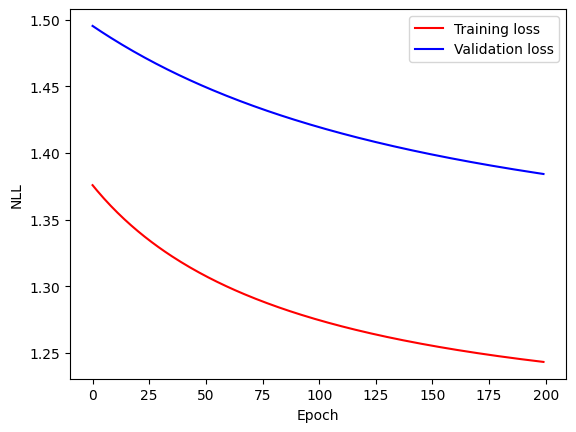

In [272]:
train_loss = []
val_loss = []

batch_size = 8

for e in range(EPOCHS):
    for b in range(int(np.ceil(len(encoded_training_set_x)/batch_size))):
        # Forward pass and loss computation

        start = b*batch_size
        end = min((b+1)*batch_size, len(encoded_training_set_x))
        # Here we use mini-batches of size `batch_size`
        # Also, we use the stored hidden state
        output = forward_batch(encoded_training_set_x[start:end], NN, use_stored_hid=False)
        Loss = sequence_loss(encoded_training_set_y[start:end], output, cross_entropy_loss_sequence)
        
        # Backward pass
        Loss.backward()
        
        # gradient descent update
        update_parameters(parameters(NN), LR)
        zero_gradients(parameters(NN))
      
    LR = LR * LR_DECAY

    # Training loss
    # Here, we use the entire training set to compute the training loss
    # (not mini-batches as above)
    # Also, we don't use the stored hidden state
    # (we want to compute the loss over the entire sequences)
    output = forward_batch(encoded_training_set_x, NN, use_stored_hid=False)
    Loss = sequence_loss(encoded_training_set_y, output, cross_entropy_loss_sequence)
    train_loss.append(Loss.v/len(encoded_training_set_y))
        
    # Validation loss
    Loss_validation = Var(0.0)
    output = forward_batch(encoded_validation_set_x, NN, use_stored_hid=False)
    Loss_validation = sequence_loss(encoded_validation_set_y, output, cross_entropy_loss_sequence)
    val_loss.append(Loss_validation.v/len(encoded_validation_set_y))
    
    if e%5==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))
        
# Plot training and validation loss
import matplotlib.pyplot as plt
%matplotlib inline
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_loss, 'r', label='Training loss',)
plt.plot(epoch, val_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

In [273]:
# Get first sentence in test set
inputs, targets = test_set[0]

# One-hot encode input and target sequence
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

# Forward pass
outputs = forward_batch(encoded_test_set_x[:1], NN)

output_sentence = [idx_to_word[np.argmax(output)] for output in Var_to_nparray(outputs[0])]

print('Input sentence:')
print(inputs)

print('\nTarget sequence:')
print(targets)

print('\nPredicted sequence:')
print([idx_to_word[np.argmax(output)] for output in Var_to_nparray(outputs[0])])

Input sentence:
['a', 'a', 'a', 'b', 'b', 'b']

Target sequence:
['a', 'a', 'b', 'b', 'b', 'EOS']

Predicted sequence:
['a', 'b', 'b', 'b', 'b', 'EOS']


/var/folders/dn/qw26xkk51853rtytqd9ns_5r0000gn/T/ipykernel_48735/161328427.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y = [[Var(float(x[i,j])) for j in range(x.shape[1])] for i in range(x.shape[0])]


## Exercise g) Extrapolation

Now that we have trained an RNN, it's time to put it to test. We will provide the network with a starting sentence and let it `freestyle` from there!

How well does your RNN extrapolate -- does it work as expected? Are there any imperfections? If yes, why could that be?

In [ ]:
def freestyle(NN, sentence='', num_generate=10):
    """
    Takes in a sentence as a string and outputs a sequence
    based on the predictions of the RNN.
    
    Args:
     `params`: the parameters of the network
     `sentence`: string with whitespace-separated tokens
     `num_generate`: the number of tokens to generate
    """
    sentence = sentence.split(' ')
    output_sentence = sentence
    sentence_one_hot = one_hot_encode_sequence(sentence, vocab_size)

    # Begin predicting
    outputs = forward_batch([sentence_one_hot], NN, use_stored_hid=False)
    output_words = [idx_to_word[np.argmax(output)] for output in Var_to_nparray(outputs[0])]
    word = output_words[-1]

    # Append first prediction
    output_sentence.append(word)

    # Forward pass - Insert code here!
    if word != 'EOS':
      for i in range(num_generate-1):
          sentence_one_hot = 
          outputs = 
          output_words = 
          word = 
          output_sentence.append(word)
          if word == 'EOS':
              break
          
    return output_sentence


# Perform freestyle (extrapolation)
test_examples = ['a a b', 'a a a a b', 'a a a a a a b', 'a', 'r n n']
for i, test_example in enumerate(test_examples):
    print(f'Example {i}:', test_example)
    print('Predicted sequence:', freestyle(NN, sentence=test_example), end='\n\n')

# Introduction to the Long Short-Term Memory (LSTM) Cell

Reading material: [Christopher Olah's walk-through](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).

___


A vanilla RNN suffers from [the vanishing gradients problem](http://neuralnetworksanddeeplearning.com/chap5.html#the_vanishing_gradient_problem) which gives challenges in saving memory over longer sequences. To combat these issues the gated hidden units were created. The two most prominent gated hidden units are the Long Short-Term Memory (LSTM) cell and the Gated Recurrent Unit (GRU), both of which have shown increased performance in saving and reusing memory in later timesteps. In this exercise, we will focus on LSTM but you would easily be able to go ahead and implement the GRU as well based on the principles that you learn here.

Below is a figure of the LSTM cell:

![lstm](https://i.imgur.com/3VkmUCe.png)
Source: https://arxiv.org/abs/1412.7828


The LSTM cell contains three gates, input, forget, output gates and a memory cell.
The output of the LSTM unit is computed with the following functions, where $\sigma = \mathrm{sigmoid}$.
We have input gate $i$, forget gate $f$, and output gate $o$ defines as

- $i = \sigma ( W^i [h_{t-1}, x_t])$

- $f = \sigma ( W^f [h_{t-1},x_t])$

- $o = \sigma ( W^o [h_{t-1},x_t])$

where $W^i, W^f, W^o$ are weight matrices applied to a concatenated $h_{t-1}$ (hidden state vector) and $x_t$ (input vector)  for each respective gate.

$h_{t-1}$, from the previous time step along with the current input $x_t$ are used to compute the a candidate $g$

- $g = \mathrm{tanh}( W^g [h_{t-1}, x_t])$

The value of the cell's memory, $c_t$, is updated as

- $c_t = c_{t-1} \circ f + g \circ i$

where $c_{t-1}$ is the previous memory, and $\circ$ refers to element-wise multiplication (hint: element-wise multiplication is computed with the `*` operator in numpy).

The output, $h_t$, is computed as

- $h_t = \mathrm{tanh}(c_t) \circ o$

and it is used for both the timestep's output and the next timestep, whereas $c_t$ is exclusively sent to the next timestep.
This makes $c_t$ a memory feature, and is not used directly to compute the output of the timestep.

## Exercise h) Make the LSTMLayer class

Make the LSTM class.

In [ ]:
# Insert code here

class LSTMLayer:
    def __init__(self, n_in: int, n_hid: int, act_fn, initializer = NormalInitializer(), initializer_hid = NormalInitializer()):
        self.n_in = n_in
        self.n_hid = n_hid
        self.g_layer = 
        self.i_layer = 
        self.f_layer = 
        self.o_layer = 
        self.initial_hid = [Var(0.0) for _ in range(n_hid)]
        self.stored_hid = [Var(0.0) for _ in range(n_hid)]
        self.initial_c = [Var(0.0) for _ in range(n_hid)]
        self.stored_c = [Var(0.0) for _ in range(n_hid)]
        self.act_fn = act_fn
    
    def __repr__(self):    
        return 'Feed-forward: ' + repr(self.in_hid_layer) + ' Candidate: ' + repr(self.g_layer) + ' i gate ' + repr(self.i_layer) + ' f gate ' + repr(self.f_layer) + ' o gate ' + repr(self.o_layer) + ' Initial hidden: ' + repr(self.initial_hid)

    def parameters(self) -> Sequence[Var]:      
      return self.in_hid_layer.parameters() + self.g_layer.parameters() + self.i_layer.parameters() + self.f_layer.parameters() + self.o_layer.parameters() + self.initial_hid

    def forward_step(self, input: Sequence[Var], input_hid: Sequence[Var], input_c: Sequence[Var]) -> Sequence[Var]:
        hids = []
        cs = []
        concatenated_input = []
        for val in input_hid:
          concatenated_input.append(val)
        for val in input:
          concatenated_input.append(val)

        # Insert code here

        return hids, cs
    
    def forward_sequence(self, input: Sequence[Sequence[Var]], use_stored_hid = False) -> Sequence[Sequence[Var]]:
        out = []
        if use_stored_hid:
            hid = self.stored_hid
            c = self.stored_c
        else:
            hid = self.initial_hid
            c = self.initial_c
        # Takes a sequence and loops over each character in the sequence. Note that each character has dimenson equal to the embeddng dimenson
        for i in range(len(input)):
            hid, c = # insert code here
            out.append(hid)
        self.stored_hid = hid
        self.stored_c = c
        return out

Here is a bit of code to test it out:

In [ ]:
NN = [
    LSTMLayer(1, 5, lambda x: x.tanh()),
    DenseLayer(5, 1, lambda x: x.identity())
]

print(NN[0])
x_train =[[[Var(1.0)], [Var(2.0)], [Var(3.0)]],
          [[Var(1.0)], [Var(2.0)], [Var(3.0)]]]

output_train = forward_batch(x_train, NN)          
output_train[0][0][0].backward()

print(output_train)

## Exercise i) LSTM training

Complete the LSTM training loop

Run the training loop. Training time in Nanograd will likely be long, but see if you can find settings to compare your LSTM learning curve (NLL and number of epochs) to the vanilla RNN from earlier. Do you observe any improvements? Motivate your answer.

Finally, below we will implement LSTM in PyTorch. You will notice it is much, much faster!

In [22]:
# Initialize training hyperparameters
EPOCHS = 
LR = 
LR_DECAY = 

In [ ]:
NN = [
    LSTMLayer(4, 1, lambda x: x.tanh()),
    DenseLayer(1, 4, lambda x: x.identity())
]

train_loss = []
val_loss = []

batch_size = 8

for e in range(EPOCHS):
    for b in range(int(np.ceil(len(encoded_training_set_x)/batch_size))):
        # Forward pass and loss computation
        Loss =
        # Backward pass
        Loss.backward()
        
        # gradient descent update
        update_parameters(parameters(NN), LR)
        zero_gradients(parameters(NN))
      
    LR = LR * LR_DECAY

    # Training loss
    Loss = 
    train_loss.append(Loss.v/len(encoded_training_set_y))
        
    # Validation loss
    Loss_validation = 
    val_loss.append(Loss_validation.v/len(encoded_validation_set_y))
    
    if e%5==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))
        
# Plot training and validation loss
import matplotlib.pyplot as plt
%matplotlib inline
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_loss, 'r', label='Training loss',)
plt.plot(epoch, val_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

## PyTorch implementation of the LSTM

Now that we know how the LSTM cell works, let's see how easy it is to use in PyTorch!

Definition of our LSTM network. We define a LSTM layer using the [nn.LSTM](https://pytorch.org/docs/stable/nn.html#lstm) class. The LSTM layer takes as argument the size of the input and the size of the hidden state like in our Nanograd implementation.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyRecurrentNet(nn.Module):
    def __init__(self):
        super(MyRecurrentNet, self).__init__()
        
        # Recurrent layer
        # YOUR CODE HERE!
        self.lstm = 
        
        # Output layer
        self.l_out = nn.Linear(in_features=50,
                            out_features=vocab_size,
                            bias=False)
        
    def forward(self, x):
        # RNN returns output and last hidden state
        x, (h, c) = self.lstm(x)
        
        # Flatten output for feed-forward layer
        x = x.view(-1, self.lstm.hidden_size)
        
        # Output layer
        x = self.l_out(x)
        
        return x

net = MyRecurrentNet()
print(net)

## Exercise j) Train in PyTorch

Define an LSTM for our recurrent neural network `MyRecurrentNet` above. A single LSTM layer is sufficient. What should the input size and hidden size be? Hint: use the PyTorch documentation.

It's time for us to train our network. In the section below, you will get to put your deep learning skills to use and create your own training loop. You may want to consult previous exercises if you cannot recall how to define the training loop.

In [ ]:
# lets redefine the one_hot_encode() and one_hot_encode_sequence() functions
# to work now with torch.Tensor variables instead of Var.
def one_hot_encode(idx, vocab_size):
    """
    One-hot encodes a single word given its index and the size of the vocabulary.
    
    Args:
     `idx`: the index of the given word
     `vocab_size`: the size of the vocabulary
    
    Returns a 1-D numpy array of length `vocab_size`.
    """
    # Initialize the encoded array
    one_hot = np.array([np.zeros(vocab_size)])
    
    # Set the appropriate element to one
    one_hot[0][idx] = 1.0
    return one_hot


def one_hot_encode_sequence(sequence, vocab_size):
    """
    One-hot encodes a sequence of words given a fixed vocabulary size.
    
    Args:
     `sentence`: a list of words to encode
     `vocab_size`: the size of the vocabulary
     
    Returns a 3-D torch.Tensor of shape (num words, vocab size, 1).
    """
    # Encode each word in the sentence
    encoding = np.array([one_hot_encode(word_to_idx[word], vocab_size) for word in sequence])

    # Reshape encoding s.t. it has shape (num words, vocab size, 1)
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[2], 1)
    return torch.Tensor(encoding)

# lets test it
test_word = one_hot_encode(word_to_idx['a'], vocab_size)
print(f'Our one-hot encoding of \'a\' has shape {test_word.shape}.')

test_sentence = one_hot_encode_sequence(['a', 'b'], vocab_size)
print(f'Our one-hot encoding of \'a b\' has shape {test_sentence.shape}.')

print(test_word)
print(test_sentence)

In [ ]:
# Hyper-parameters
num_epochs = 200

# Initialize a new network
net = MyRecurrentNet()

# Define a loss function and optimizer for this problem
# YOUR CODE HERE!
criterion = 
optimizer = 

# Track loss
training_loss, validation_loss = [], []

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    net.eval()
        
    # For each sentence in validation set
    for inputs, targets in validation_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_idx = [word_to_idx[word] for word in targets]
        
        # Convert input to tensor
        inputs_one_hot = torch.Tensor(inputs_one_hot)
        inputs_one_hot = inputs_one_hot.permute(0, 2, 1)
        
        # Convert target to tensor
        targets_idx = torch.LongTensor(targets_idx)
        
        # Forward pass
        # YOUR CODE HERE!
        outputs = 
        
        # Compute loss
        # YOUR CODE HERE!
        loss = 
        
        # Update loss
        epoch_validation_loss += loss.detach().numpy()
    
    net.train()
    
    # For each sentence in training set
    for inputs, targets in training_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_idx = [word_to_idx[word] for word in targets]
        
        # Convert input to tensor
        inputs_one_hot = torch.Tensor(inputs_one_hot)
        inputs_one_hot = inputs_one_hot.permute(0, 2, 1)
        
        # Convert target to tensor
        targets_idx = torch.LongTensor(targets_idx)
        
        # Forward pass
        # YOUR CODE HERE!
        outputs = 
        
        # Compute loss
        # YOUR CODE HERE!
        loss = 
        
        # Backward pass
        # YOUR CODE HERE!
        # zero grad, backward, step...
        
        # Update loss
        epoch_training_loss += loss.detach().numpy()
        
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    # Print loss every 10 epochs
    if i % 10 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')

        
# Get first sentence in test set
inputs, targets = test_set[1]

# One-hot encode input and target sequence
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_idx = [word_to_idx[word] for word in targets]

# Convert input to tensor
inputs_one_hot = torch.Tensor(inputs_one_hot)
inputs_one_hot = inputs_one_hot.permute(0, 2, 1)

# Convert target to tensor
targets_idx = torch.LongTensor(targets_idx)

# Forward pass
outputs = net.forward(inputs_one_hot).data.numpy()

print('\nInput sequence:')
print(inputs)

print('\nTarget sequence:')
print(targets)

print('\nPredicted sequence:')
print([idx_to_word[np.argmax(output)] for output in outputs])

# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

# Exercise k) Compare PyTorch and Nanograd implementations

Compare the two implementations (in terms of predictive performance, training speed, etc.). Are they similar? How do they differ?


Try to play around with the choice of hyper-parameters, optimizer, and hidden dimensions. How much can you improve the negative log-likelihood by these simple changes?

## Exercise l) Other RNN cells (optional)

Aside from the LSTM cell, various other RNN cells exist. The gated recurrent unit (GRU) is a variation of the LSTM cell that uses less gating mechanisms. Try to look it up in the [PyTorch documentation](https://pytorch.org/docs/stable/nn.html#gru) and switch out the LSTM cell in the code above. What do you notice in terms of performance and convergence speed?

## Exercise m) More complex tasks (optional)

Go back and generate a more complex patterned dataset to learn from. Do you see any significant differences between a vanilla RNN and LSTM (implemented in e.g. PyTorch) when you increase the difficulty of the task?

# It works, now what?

In this notebook you have learned how to use embeddings, recurrent neural networks, and the LSTM cell in particular.

As we have already seen, RNNs are excellent for sequential data such as language. But what do we do if we're modelling data with strong dependency in both directions? Like in many things deep learning, we can build powerful models by stacking layers on top of each other; *bi-directional* RNNs consist of two LSTM cells, one for each direction. A sequence is first fed into the forward LSTM cell and the reversed sequence is then used as input to the backward LSTM cell together with the last hidden state from the forward LSTM cell. Follow [this link](https://pdfs.semanticscholar.org/4b80/89bc9b49f84de43acc2eb8900035f7d492b2.pdf) for the original paper from 1997(!).

For even deeper representations, multiple layers of both uni-directional and bi-directional RNNs can be stacked ontop of each other, just like feed-forward and convolutional layers. For more information on this, check out the [LSTM PyTorch documentation](https://pytorch.org/docs/stable/nn.html#lstm). Next week we will also explore ways to combine RNNs with other types of layers for even more expressive function approximators.